# **MNIST Classifier**

In [1]:
# import
import torch
import torchvision
import nin
import rotnet_config
from dataloader import DataLoader, GenericDataset
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from utils import load_data_for_rotnet, load_data_for_mnist, nbr_total_pred
import non_linear_classifier
import mnist_classifier_config
from torchsummary import summary

In [2]:
# data loading
dloader_train, dloader_test = load_data_for_mnist()
print(f'num_imgs_per_category: {mnist_classifier_config.data_train_opt["num_imgs_per_cat"]}')
print(f"nimber total of label data: {len(dloader_train.dataset.data.targets)}")

/home/bdiarra/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/home/bdiarra/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/bdiarra/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


num_imgs_per_category: 10
nimber total of label data: 100


In [3]:
# model creation
mnist_classifier = non_linear_classifier.create_model(mnist_classifier_config.cls_net_opt)
rotnet_nin = nin.create_model(rotnet_config.net_opt)
rotnet_nin.load_state_dict(torch.load("./models_save_dir/rotnet/model_epoch_8")['model_state_dict'])
if torch.cuda.is_available():
    mnist_classifier.cuda()
    rotnet_nin.cuda()
rotnet_nin.eval()
print('')

In [4]:
#model summary
summary(mnist_classifier, (192,8,8), batch_size=32, device='cuda' )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 192, 8, 8]         331,776
       BatchNorm2d-2            [32, 192, 8, 8]             384
              ReLU-3            [32, 192, 8, 8]               0
        BasicBlock-4            [32, 192, 8, 8]               0
            Conv2d-5            [32, 192, 8, 8]          36,864
       BatchNorm2d-6            [32, 192, 8, 8]             384
              ReLU-7            [32, 192, 8, 8]               0
        BasicBlock-8            [32, 192, 8, 8]               0
            Conv2d-9            [32, 192, 8, 8]          36,864
      BatchNorm2d-10            [32, 192, 8, 8]             384
             ReLU-11            [32, 192, 8, 8]               0
       BasicBlock-12            [32, 192, 8, 8]               0
    GlobalAvgPool-13                  [32, 192]               0
           Linear-14                   

In [5]:
#optimizer creeation
learning_rate = mnist_classifier_config.cls_net_optim_params['lr']
params = mnist_classifier.parameters()
optimizer_mnist = torch.optim.SGD(params,
                        lr=learning_rate,
                        momentum=mnist_classifier_config.cls_net_optim_params['momentum'],
                        nesterov=mnist_classifier_config.cls_net_optim_params['nesterov'],
                        weight_decay=mnist_classifier_config.cls_net_optim_params['weight_decay']
                        )

In [6]:
# training and testing
train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

# loss function
cross_entropy_loss = torch.nn.CrossEntropyLoss()

# number of epoch
nb_epoch = mnist_classifier_config.config['max_num_epochs']


def train(epoch):
    mnist_classifier.train()
    epoch_loss = []
    total_label = 0
    total_correct_pred = 0
    for _, batch in enumerate(tqdm(dloader_train(epoch), ascii=True, desc=f"epoch_{epoch + 1}/{nb_epoch}")):
        dataX = torch.FloatTensor()
        labels = torch.LongTensor()
        dataX.resize_(batch[0].size()).copy_(batch[0])
        labels.resize_(batch[1].size()).copy_(batch[1])

        with torch.no_grad():
            dataX_var = torch.autograd.Variable(dataX)
            if torch.cuda.is_available():
                dataX_var = dataX_var.cuda()
            feat_var = rotnet_nin(dataX_var, out_feat_keys=['conv2'])

        labels_var = torch.autograd.Variable(labels, requires_grad=False)
        dataX_var = torch.autograd.Variable(feat_var)
        if torch.cuda.is_available():
            dataX_var = dataX_var.cuda()
            labels_var = labels_var.cuda()
        pred_var = mnist_classifier(feat_var)

        # compute the loss
        loss = cross_entropy_loss(pred_var, labels_var)
        epoch_loss.append(loss.item())

        # compute the number of correct prediction
        total_correct_pred += nbr_total_pred(pred_var, labels_var)
        total_label += labels_var.size(0)

        # backpropagation
        optimizer_mnist.zero_grad()
        loss.backward()
        optimizer_mnist.step()
    epoch_loss = sum(epoch_loss) / len(epoch_loss)
    accuracy = 100.0 * total_correct_pred / total_label
    train_loss.append(epoch_loss)
    train_accuracy.append(accuracy)

    # create checkpoint (it will be use later for transfer learning stage)
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': mnist_classifier.state_dict(),
            'optimizer_state_dict': optimizer_mnist.state_dict(),
            'loss': train_loss[-1]
        }, f"./models_save_dir/mnist/model_epoch_{epoch + 1}"
    )

    print(f"Train Loss: {epoch_loss} | Accuracy: {accuracy} %")


def test(epoch):
    mnist_classifier.eval()
    epoch_loss = []
    total_label = 0
    total_correct_pred = 0
    with torch.no_grad():
        for _, batch in enumerate(tqdm(dloader_test(epoch), ascii=True, desc=f"Test of epoch_{epoch + 1}")):
            dataX = torch.FloatTensor()
            labels = torch.LongTensor()
            dataX.resize_(batch[0].size()).copy_(batch[0])
            labels.resize_(batch[1].size()).copy_(batch[1])
            dataX_var = torch.autograd.Variable(dataX)
            labels_var = torch.autograd.Variable(labels, requires_grad=False)
            if torch.cuda.is_available():
                dataX_var = dataX_var.cuda()
                labels_var = labels_var.cuda()
            feat_var = rotnet_nin(dataX_var, out_feat_keys=['conv2'])
            pred_var = mnist_classifier(feat_var)

            # compute the loss
            loss = cross_entropy_loss(pred_var, labels_var)
            epoch_loss.append(loss.item())

            # compute the number of correct prediction
            total_correct_pred += nbr_total_pred(pred_var, labels_var)
            total_label += labels_var.size(0)
        epoch_loss = sum(epoch_loss) / len(epoch_loss)
        accuracy = 100.0 * total_correct_pred / total_label
        test_loss.append(epoch_loss)
        test_accuracy.append(accuracy)

        print(f"Test Loss: {epoch_loss} | Accuracy: {accuracy} %")


def fit(nb_epoch):
    for epoch in range(nb_epoch):
        train(epoch)
        test(epoch)


fit(nb_epoch)

epoch_1/10: 100%|##########| 1875/1875 [01:20<00:00, 23.16it/s]


Train Loss: 0.013732169721275568 | Accuracy: 99.78 %


Test of epoch_1: 100%|##########| 313/313 [00:12<00:00, 25.53it/s]


Test Loss: 0.31226514605954053 | Accuracy: 90.07 %


epoch_2/10: 100%|##########| 1875/1875 [01:28<00:00, 21.26it/s]


Train Loss: 0.0020250013088807463 | Accuracy: 100.0 %


Test of epoch_2: 100%|##########| 313/313 [00:12<00:00, 25.35it/s]


Test Loss: 0.2964184710848184 | Accuracy: 90.69 %


epoch_3/10: 100%|##########| 1875/1875 [01:27<00:00, 21.50it/s]


Train Loss: 0.002202107565042873 | Accuracy: 100.0 %


Test of epoch_3: 100%|##########| 313/313 [00:11<00:00, 26.46it/s]


Test Loss: 0.29719923303935664 | Accuracy: 91.18 %


epoch_4/10: 100%|##########| 1875/1875 [01:25<00:00, 21.85it/s]


Train Loss: 0.002351848750313123 | Accuracy: 100.0 %


Test of epoch_4: 100%|##########| 313/313 [00:13<00:00, 23.14it/s]


Test Loss: 0.30061123080956287 | Accuracy: 91.26 %


epoch_5/10: 100%|##########| 1875/1875 [01:30<00:00, 20.70it/s]


Train Loss: 0.0023564885358015697 | Accuracy: 100.0 %


Test of epoch_5: 100%|##########| 313/313 [00:12<00:00, 25.96it/s]


Test Loss: 0.3459290816796759 | Accuracy: 89.95 %


epoch_6/10: 100%|##########| 1875/1875 [01:24<00:00, 22.18it/s]


Train Loss: 0.0025055591431756815 | Accuracy: 100.0 %


Test of epoch_6: 100%|##########| 313/313 [00:11<00:00, 26.33it/s]


Test Loss: 0.40095662087582934 | Accuracy: 88.97 %


epoch_7/10: 100%|##########| 1875/1875 [01:22<00:00, 22.85it/s]


Train Loss: 0.007060171853440504 | Accuracy: 99.95833333333333 %


Test of epoch_7: 100%|##########| 313/313 [00:11<00:00, 26.45it/s]


Test Loss: 0.3270108442063244 | Accuracy: 89.92 %


epoch_8/10: 100%|##########| 1875/1875 [01:23<00:00, 22.37it/s]


Train Loss: 0.002357741318705181 | Accuracy: 100.0 %


Test of epoch_8: 100%|##########| 313/313 [00:12<00:00, 24.96it/s]


Test Loss: 0.39932177357447035 | Accuracy: 88.28 %


epoch_9/10: 100%|##########| 1875/1875 [01:24<00:00, 22.16it/s]


Train Loss: 0.002632116094821443 | Accuracy: 100.0 %


Test of epoch_9: 100%|##########| 313/313 [00:11<00:00, 26.72it/s]


Test Loss: 0.36105936135465916 | Accuracy: 89.56 %


epoch_10/10: 100%|##########| 1875/1875 [01:22<00:00, 22.67it/s]


Train Loss: 0.003043139598922183 | Accuracy: 99.99666666666667 %


Test of epoch_10: 100%|##########| 313/313 [00:12<00:00, 25.95it/s]

Test Loss: 0.38690685040463274 | Accuracy: 88.69 %


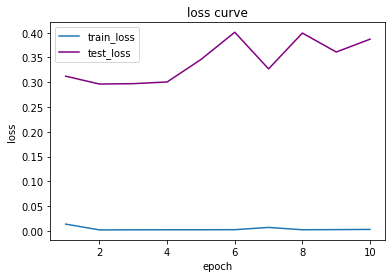

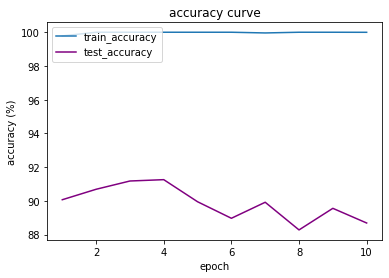

In [7]:
# Vislualise loss and accuracy curve
plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), train_loss, label='train_loss')
fig = plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), test_loss, label='test_loss', c='purple')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("loss curve")
plt.savefig('./figs/loss_curve_minist_model')
plt.show()
print()
plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), train_accuracy, label='train_accuracy')
plt.plot(np.linspace(1, nb_epoch,nb_epoch).astype(int), test_accuracy, label='test_accuracy', c='purple')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.title("accuracy curve")
plt.savefig(f'./figs/accuracy_curve_mnist_model_with_{mnist_classifier_config.data_train_opt["num_imgs_per_cat"]}')
plt.show()

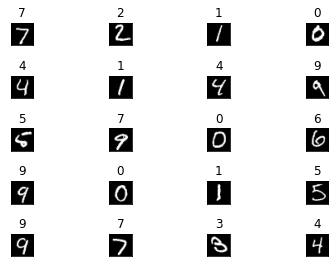

In [4]:
# Prediction after training
# we load the model with the best epoch
mnist_classifier = non_linear_classifier.create_model(mnist_classifier_config.cls_net_opt)
mnist_classifier.load_state_dict(torch.load("./models_save_dir/mnist/model_epoch_4")['model_state_dict'])
if torch.cuda.is_available():
    mnist_classifier.cuda()

for b in dloader_test(0):
    data, label = b
    break

inv_transform = dloader_train.inv_transform

if torch.cuda.is_available():
    data_cuda = data.cuda()
else:
    data_cuda = data
mnist_classifier.eval()
with torch.no_grad():
    feat_var = rotnet_nin(data_cuda, out_feat_keys=['conv2'])
    _, pred = mnist_classifier(feat_var).data.max(1)

    for i in range(20):
        plt.subplot(5, 4, i + 1)
        plt.tight_layout()
        plt.title(f"{pred[i].item()}")
        fig = plt.imshow(inv_transform(data[i]).squeeze(), cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.savefig(
        f'./figs/mnist_img_4x4_pred_after_training_with_{mnist_classifier_config.data_train_opt["num_imgs_per_cat"]}')
    plt.show()